
## Predicting Project Approval on DonorsChoose.org
---
> The DonorsChoose.org portal receives a staggering number of classroom project proposals (hundreds of thousands!) each year. Manually reviewing each one by a large volunteer force is becoming unsustainable.

The **objective** is to streamline the screening process and ensure all proposals receive a fair and consistent review. This will help in freeing up volunteer time to focus on proposals that require more hands-on guidance.


---




***This is where you come in!***  

**Problem Statement ->** Your goal is to develop a system that predicts project approval based on the teacher's description, along with other details about the project, teacher, and school.


**Steps**
1. Data Collection, Exploration and Preprocessing
2. EDA
3. Pre-Modelling Data Preparation
4. Model Building
5. Model Evaluation
6. Summary



---



## Data Collection, Exploration and Preprocessing

In [1]:
# ## 1. Data Collection

# ### Import Libraries
# Import the necessary libraries for loading data and data manipulation
import os
import gdown
import zipfile
import pandas as pd
import numpy as np

# ### Download Dataset
# The dataset can be downloaded using the provided code. The data will be extracted into a specified directory.
dataset_url = "https://drive.google.com/uc?export=download&id=1KrnpfYRKVxGDnj-R2VZmNscEkR1zr2-4"
dataset_path = "./dataset/donors_choose" # the dataset will be downloaded in this folder
zip_file_path = os.path.join(dataset_path, "donors_choose_dataset.zip")

if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)
if not os.path.exists(zip_file_path):
    gdown.download(dataset_url, zip_file_path, quiet=False)
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        zip_ref.extractall(dataset_path)

---


### **Accessing the dataset**
To access the dataset, open the **Files** section by clicking the folder icon on the left pane; it should display the label 'Files' when you hover over it.

> Within the Files section, you will find a folder named dataset. Inside this folder, there is another folder called *donors_choose*.

> Within the donors_choose folder, you will find two CSV files:
1. train_data.csv
2. resources.csv

These two CSV files make up the dataset.

In [2]:
# First, load the two CSV files into separate dataframes using pandas.
# Type your code below.

train_df = pd.read_csv(os.path.join(dataset_path, "train_data.csv"))
resources_df = pd.read_csv(os.path.join(dataset_path, "resources.csv"))

Provide a summary of each dataframe, including its size, features, target variable, and data types.

In [3]:
# View the top few rows of both the dataframe
# Type the code here

# DataFrame size
print(f"Training Data Size: {train_df.shape[0]} rows, {train_df.shape[1]} columns")
print(f"Resource Data Size: {resources_df.shape[0]} rows, {resources_df.shape[1]} columns")

# Features (columns)
print("\nFeatures:")
print(f"Training Data Features (Columns): {train_df.columns.tolist()}")
print(f"Training Data Features (Columns): {resources_df.columns.tolist()}")

# Target variable (if provided)
target_variable = "project_is_approved"
if target_variable:
    if target_variable in train_df.columns:
        print(f"\nTarget Variable: {target_variable}")
        print(f"Approved Projects Count: {train_df[train_df['project_is_approved'] == 1].shape[0]}")
        print(f"Unapproved Projects Count: {train_df[train_df['project_is_approved'] == 0].shape[0]}")
        print(f"Approved Project percentage in total: {train_df[train_df['project_is_approved'] == 1].shape[0] / train_df.shape[0]}")
        # print(train_df[target_variable].value_counts())
    else:
        print(f"\nTarget variable '{target_variable}' not found in DataFrame.")

# Data Infos
print("\n==========Summary of Training Data:==========")
train_df.info()
print("\n==========Summary of Resource Data:==========")
resources_df.info()

# Summary statistics
print("\n==========Summary Statistics of Training Data(Numerical):==========")
print(train_df.describe())
print("\n==========Summary Statistics of Resource Data(Numerical):==========")
print(resources_df.describe())

# Summary statistics for categorical features
print("\n==========Summary Statistics of Training Data (Categorical):==========")
print(train_df.describe(include='object'))
print("\n==========Summary Statistics of Resources Data (Categorical):==========")
print(resources_df.describe(include='object'))


Training Data Size: 109248 rows, 17 columns
Resource Data Size: 1541272 rows, 4 columns

Features:
Training Data Features (Columns): ['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state', 'project_submitted_datetime', 'project_grade_category', 'project_subject_categories', 'project_subject_subcategories', 'project_title', 'project_essay_1', 'project_essay_2', 'project_essay_3', 'project_essay_4', 'project_resource_summary', 'teacher_number_of_previously_posted_projects', 'project_is_approved']
Training Data Features (Columns): ['id', 'description', 'quantity', 'price']

Target Variable: project_is_approved
Approved Projects Count: 92706
Unapproved Projects Count: 16542
Approved Project percentage in total: 0.8485830404217927

==========Summary of Training Data:==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109248 entries, 0 to 109247
Data columns (total 17 columns):
 #   Column                                        Non-Null Count   Dtype 
---  ------       

#### **Understanding the Dataset**
We have included some additional information below to help you understand better.

The `train.csv` data set provided by DonorsChoose contains the following features -->

Feature | Description
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul>
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul>
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul>
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup>
**`project_essay_3`**    | Third application essay<sup>*</sup>
**`project_essay_4`**    | Fourth application essay<sup>*</sup>
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2`



---

**Notes on the Essay Data**

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_4:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>



---


Additionally, the `resources.csv` data set provides more data about the resources required for each project.

Feature | Description
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required (each unit). **Example:** `9.95`   

---


#### **To predict (Output/Target Feature)**
The `train.csv` contains the following column (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.


In [4]:
## Using appropriate methods check the datatypes and null values in the different columns of train_df

# Check datatypes of each column
print(train_df.dtypes)

# Check for null values in each column
print(train_df.isnull().sum())

train_df.info()

Unnamed: 0                                       int64
id                                              object
teacher_id                                      object
teacher_prefix                                  object
school_state                                    object
project_submitted_datetime                      object
project_grade_category                          object
project_subject_categories                      object
project_subject_subcategories                   object
project_title                                   object
project_essay_1                                 object
project_essay_2                                 object
project_essay_3                                 object
project_essay_4                                 object
project_resource_summary                        object
teacher_number_of_previously_posted_projects     int64
project_is_approved                              int64
dtype: object
Unnamed: 0                                         

In [5]:
## Check the shape of train_df
print(f"Training Data Size: {train_df.shape[0]} rows, {train_df.shape[1]} columns")

Training Data Size: 109248 rows, 17 columns


In [6]:
## Using appropriate methods check the datatypes and null values in the different columns of resources_df

# Check datatypes of each column
print(resources_df.dtypes)

# Check for null values in each column
print(resources_df.isnull().sum())

resources_df.info()

id              object
description     object
quantity         int64
price          float64
dtype: object
id               0
description    292
quantity         0
price            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1541272 entries, 0 to 1541271
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   id           1541272 non-null  object 
 1   description  1540980 non-null  object 
 2   quantity     1541272 non-null  int64  
 3   price        1541272 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 47.0+ MB


In [7]:
## Check the shape of resources_df
print(f"Resource Data Size: {resources_df.shape[0]} rows, {resources_df.shape[1]} columns")

Resource Data Size: 1541272 rows, 4 columns


In [8]:
## Check the data consistency between the train_df and resources_df dataframes
## Check if both the dataframes contain same or different application ids

# 'id' is the column in both dataframes
train_ids = set(train_df['id'])
resources_ids = set(resources_df['id'])


# Size of train and resources id dataframes
if(len(train_ids) != len(resources_ids)):
    print(f"Either train_df or resources_df doesn't contain same number of IDs.")
    print(f"Size of unique id train_df: {len(train_ids)}")
    print(f"Size of unique id resources_df: {len(resources_ids)}")
else:
    print(f"Both Train and Resource have same number of IDs: {len(train_ids)}")

# Find IDs that are in train_df but not in resources_df
missing_in_resources = train_ids - resources_ids
if(len(missing_in_resources) > 0):
    print(f"Ids in train_df but not in resources_df: {missing_in_resources}")
else:
    print(f"All Ids in resource exists in Train")

# Find IDs that are in resources_df but not in train_df
missing_in_train = resources_ids - train_ids
if(len(missing_in_train) > 0):
    print(f"Ids in resources_df but not in train_df: {len(missing_in_train)}.")
else:
    print(f"All Ids in train exists in resource")


Either train_df or resources_df doesn't contain same number of IDs.
Size of unique id train_df: 109248
Size of unique id resources_df: 260115
All Ids in resource exists in Train
Ids in resources_df but not in train_df: 150867.


In [9]:
# Find the missing value in project_essay_3 & project_essay_3 is legitimate

# Filter rows where both project_essay_3 and project_essay_4 are null
filtered_df = train_df[train_df['project_essay_3'].isnull() & train_df['project_essay_4'].isnull()]

# Check if creation_time of the project record is less or equal to 2016-05-17, then it is legtimate
cut_off_date = pd.to_datetime('2016-05-17 00:00:00')
records_need_attention_3_Proj3_Proj4 = filtered_df[pd.to_datetime(filtered_df['project_submitted_datetime']) <= cut_off_date]

# Check if there is any project record with project_essay_3 and project_essay_4 is null though the records are created after 2016-05-17
if len(records_need_attention_3_Proj3_Proj4) > 0:
    print("Check the null values of project_essay_3 and project_essay_4 in the following records:")
    print(records_need_attention_3_Proj3_Proj4)
else:
    print("All the project records project3 and project4 are legitimate")


All the project records project3 and project4 are legitimate


**Observations**

*Document your observations for the analysis done till now around missing values, data types and data consistency*

- **resources data** - all columns are in correct data type, all the required values are available, description for 292 records are missing, but it is not so critical to worry about.
- **training data** - No missing values, project3 and project4 essay are missing but they are all the records created after 2016-05-17, so it is legitimate. But the datatype are all string, we need to convert the categorical ordinal and nominal data to the right format.
- **Combination of resoruces and training data** - All the resources details covered in training data exists in resources data. resources data has some more values that is not required for this training, but it is not a worry, we can ignore them. So aggregating training and resource data will not be a problem.

#### Creating the Master Dataframe - project_data

Before proceeding with doing the data sanity checks as documented above, you need to combine the two dataframes train_df into a single dataframe by merging them on the `project-ids`

> **Note:** Each line in the resources.csv file represents a resource required by a project. Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project. Also the `price` column denotes the price per unit of the item denoted by the `description` column

##### Perform these steps to complete this task:
- Using the `resources_df`,  create a new dataframe that contains the project_id, total quantity of resources for each project and total amount required for all the resources for that project.
- Merge this new dataframe with the `train_df` dataframe. Peform an inner join.
- Name this dataframe as `project_data`

In [10]:
## Write your code here to generate the new dataframe from resources_df
## Hint - You might have to create a new column and perform a groupby

# Step 1: Create a new column 'total_price' by multiplying 'unit price' with 'item quantity'
resources_df['total_price_per_row'] = resources_df['quantity'] * resources_df['price']

# Step 2: Group by 'id' and aggregate 'item quantity' and 'total_price_per_row'
aggregated_df = resources_df.groupby('id').agg({'quantity': 'sum', 'total_price_per_row': 'sum'}).reset_index()

# Step3: Rename the columns appropriately
aggregated_df = aggregated_df.rename(columns={'total_price_per_row': 'total_price'})
aggregated_df = aggregated_df.rename(columns={'quantity': 'total_quantity'})
aggregated_df = aggregated_df.rename(columns={'id': 'project_id'})

# Display the resulting DataFrame
print(aggregated_df)

       project_id  total_quantity  total_price
0         p000001               7       833.63
1         p000002              21       630.28
2         p000003               4       298.97
3         p000004              98      1126.22
4         p000005               8       702.31
...           ...             ...          ...
260110    p260111              27       176.08
260111    p260112               6       119.37
260112    p260113               3       811.49
260113    p260114              39       749.27
260114    p260115               2       318.97

[260115 rows x 3 columns]


In [11]:
## Write the code to perform the merge operation
## Name this new dataframe as project_data

# Merge the dataframes on 'project_id' from train_df and 'id' from aggregated_df
project_data = pd.merge(train_df, aggregated_df, how='inner', left_on='id', right_on='project_id')

# Drop the 'id' column from the result if it is no longer needed (optional)
project_data.drop(['id'], axis = 1, inplace = True)

# How to reorder the columns in pandas data frame?

# Get the list of column names
columns = project_data.columns.tolist()
# Remove the 16th column (index 16, since indexing is 0-based)
col_to_move = columns.pop(16)  # 16 column
# Insert the 16th column at the 2nd position (index 1)
columns.insert(1, col_to_move)
# Reassign the DataFrame with the new column order
project_data = project_data[columns]

print(project_data.head())

project_data.info()

   Unnamed: 0 project_id                        teacher_id teacher_prefix  \
0      160221    p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945    p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895    p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   
3          45    p246581  f3cb9bffbba169bef1a77b243e620b60           Mrs.   
4      172407    p104768  be1f7507a41f8479dc06f047086a39ec           Mrs.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   
2           AZ        2016-08-31 12:03:56             Grades 6-8   
3           KY        2016-10-06 21:16:17          Grades PreK-2   
4           TX        2016-07-11 01:10:09          Grades PreK-2   

            project_subject_categories     project_subject_subcategories  \
0                  Literacy & Language              

***Checklist***

Before proceeding further, check
- the shape of `project_data`. There should be around 100k rows and 17-18 columns
- the datatypes of all the variables, most should be object datatype with a few numeric columns
- the columns containing null values, should be around 3 columns

In [12]:
## Write the code to check the above
print(f"Project Data Size: {project_data.shape[0]} rows, {project_data.shape[1]} columns")
project_data.info()

Project Data Size: 109248 rows, 19 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109248 entries, 0 to 109247
Data columns (total 19 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   Unnamed: 0                                    109248 non-null  int64  
 1   project_id                                    109248 non-null  object 
 2   teacher_id                                    109248 non-null  object 
 3   teacher_prefix                                109245 non-null  object 
 4   school_state                                  109248 non-null  object 
 5   project_submitted_datetime                    109248 non-null  object 
 6   project_grade_category                        109248 non-null  object 
 7   project_subject_categories                    109248 non-null  object 
 8   project_subject_subcategories                 109248 non-null  object 
 9   proje

Once the checks are done, proceed further

#### Missing Value Treatment

**project_essay columns**

Some of the `project_essay_*` columns contain null values. Revisit the `Understanding the Data` section to understand why this is so

In [13]:
## Identify a suitable strategy to treat the missing values
## Hint - One possible strategy could be to create a combined column of all the essay columns
## And then remove the original project_essay_* columns

# Check for 'project_data' column, if it exists already the data was processed, nothing to do.
# Else process the data by combining 'project_essay_*' columns
if 'project_essay' not in project_data.columns:
    # Step 1: Combine the 3 project columns into one 'project' column.
    # We can use fillna or combine_first to fill in non-null values from other columns    
    project_data['project_essay'] = project_data['project_essay_1'].fillna('') + project_data['project_essay_2'].fillna('') + project_data['project_essay_3'].fillna('') + project_data['project_essay_4'].fillna('')

    # Alternatively, you could use .apply with a lambda for row-wise combination:
    # df['project'] = df[['project_essay_1', 'project_essay_2', 'project_essay_3', 'project_essay_4']].apply(lambda x: ' '.join(x.dropna()), axis=1)

    # Step 2: Drop the original 'project1', 'project2', 'project3' columns
    project_data.drop(['project_essay_1', 'project_essay_2', 'project_essay_3', 'project_essay_4'], axis=1, inplace=True)

print(project_data.head())

project_data.info()

   Unnamed: 0 project_id                        teacher_id teacher_prefix  \
0      160221    p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945    p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895    p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   
3          45    p246581  f3cb9bffbba169bef1a77b243e620b60           Mrs.   
4      172407    p104768  be1f7507a41f8479dc06f047086a39ec           Mrs.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   
2           AZ        2016-08-31 12:03:56             Grades 6-8   
3           KY        2016-10-06 21:16:17          Grades PreK-2   
4           TX        2016-07-11 01:10:09          Grades PreK-2   

            project_subject_categories     project_subject_subcategories  \
0                  Literacy & Language              

**teacher_prefix** column

`teacher_prefix` has a few missing values. Develop a suitable strategy to fix this

In [14]:
## Write your code here

if len(project_data[project_data['teacher_prefix'].isnull()]) > 0:
    print("Replacing the missing values with 'NotPrefered' because all the teacher_prefix records are available")
    project_data['teacher_prefix'].fillna('NotPrefered', inplace=True)
else:
    print("All the teacher_prefix records are available")
    
project_data.info()

Replacing the missing values with 'NotPrefered' because all the teacher_prefix records are available
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109248 entries, 0 to 109247
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   Unnamed: 0                                    109248 non-null  int64  
 1   project_id                                    109248 non-null  object 
 2   teacher_id                                    109248 non-null  object 
 3   teacher_prefix                                109248 non-null  object 
 4   school_state                                  109248 non-null  object 
 5   project_submitted_datetime                    109248 non-null  object 
 6   project_grade_category                        109248 non-null  object 
 7   project_subject_categories                    109248 non-null  object 
 8   project_subject_subcate

/var/folders/8k/p4xbwcxn34x7b1nj4s53zdsw0000gn/T/ipykernel_73917/3584341742.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  project_data['teacher_prefix'].fillna('NotPrefered', inplace=True)


***Checklist***

Before proceeding further, check
- null values in the dataframe. There should be none
- first few rows of the dataframe for inspection purpose

In [15]:
## Write your code here

pd.set_option('display.max_colwidth', 20)

# Check for null values in each column
print("Is there any missing values?")
print(project_data.isnull().sum())

project_data.head(5)

Is there any missing values?
Unnamed: 0                                      0
project_id                                      0
teacher_id                                      0
teacher_prefix                                  0
school_state                                    0
project_submitted_datetime                      0
project_grade_category                          0
project_subject_categories                      0
project_subject_subcategories                   0
project_title                                   0
project_resource_summary                        0
teacher_number_of_previously_posted_projects    0
project_is_approved                             0
total_quantity                                  0
total_price                                     0
project_essay                                   0
dtype: int64


,Unnamed: 0,project_id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,total_quantity,total_price,project_essay
0,160221,p253737,c90749f5d961ff15...,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Supp...,My students need...,0,0,23,596.36,My students are ...
1,140945,p258326,897464ce9ddc600b...,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,History & Civics...,Civics & Governm...,Wanted: Projecto...,My students need...,7,1,1,299.00,Our students arr...
2,21895,p182444,3465aaf82da834c0...,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Health & Sports,Health & Wellnes...,Soccer Equipment...,My students need...,1,0,22,686.68,"\r\n\""True champ..."
3,45,p246581,f3cb9bffbba169be...,Mrs.,KY,2016-10-06 21:16:17,Grades PreK-2,Literacy & Langu...,"Literacy, Mathem...",Techie Kindergar...,My students need...,4,1,4,431.90,I work at a uniq...
4,172407,p104768,be1f7507a41f8479...,Mrs.,TX,2016-07-11 01:10:09,Grades PreK-2,Math & Science,Mathematics,Interactive Math...,My students need...,1,1,4,143.96,Our second grade...


With this the first section of the code notebook is now completed. Now, let's proceed to the next section on Exploratory Data Analysis or EDA. Before that, let's make some additional necessary imports

In [16]:
## Additional imports
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import pickle

from tqdm import tqdm
import os
import zipfile

## EDA (Exploratory Data Analysis)

For this section, you have to compute various univariate and bivariate analysis for the different columns of interest in the `project_data` dataframe.
You have the freedom to do as much analysis as possible. However, for the sake of brevity, we are suggesting the following tasks

In [17]:
# Preprocess the project_data before writing code for additional analysis
temp_data = project_data.copy()

# Label Encoding: Use when the state names have an implicit order (though typically they don’t).
# LabelEncoder = preprocessing.LabelEncoder()
# temp_data['school_state'] =  LabelEncoder.fit_transform(temp_data['school_state'])

# One-Hot Encoding: Best when the states are categorical and you want to prevent the model from assuming any ordinal relationship.
# temp_data = pd.get_dummies(temp_data, columns=['teacher_prefix', 'school_state'], prefix=['teacher_prefix', 'school_state'])

# Categorical Type: Useful for memory efficiency and can also be used directly in certain models that support categorical variables.
temp_data['school_state'] = temp_data['school_state'].astype('category')
temp_data['teacher_prefix'] = temp_data['teacher_prefix'].astype('category')
temp_data['project_grade_category'] = temp_data['project_grade_category'].astype('category')
temp_data['project_subject_categories'] = temp_data['project_subject_categories'].astype('category')
temp_data['project_subject_subcategories'] = temp_data['project_subject_subcategories'].astype('category')
temp_data['project_submitted_datetime'] = pd.to_datetime(temp_data['project_submitted_datetime'])

print( f"project_grade_category: {temp_data['project_grade_category'].value_counts()}")
print( f"project_subject_categories: {temp_data['project_subject_categories'].value_counts()}")
print( f"project_subject_subcategories: {temp_data['project_subject_subcategories'].value_counts()}")

print(temp_data.info())

project_grade_category: project_grade_category
Grades PreK-2    44225
Grades 3-5       37137
Grades 6-8       16923
Grades 9-12      10963
Name: count, dtype: int64
project_subject_categories: project_subject_categories
Literacy & Language                           23655
Math & Science                                17072
Literacy & Language, Math & Science           14636
Health & Sports                               10177
Music & The Arts                               5180
Special Needs                                  4226
Literacy & Language, Special Needs             3961
Applied Learning                               3771
Math & Science, Literacy & Language            2289
Applied Learning, Literacy & Language          2191
History & Civics                               1851
Math & Science, Special Needs                  1840
Literacy & Language, Music & The Arts          1757
Math & Science, Music & The Arts               1642
Applied Learning, Special Needs                1467


**EDA-1**: What is the percentage (fraction) and number of projects that are approved versus not approved? Create a visualization of the results.

In [18]:
# Categorical Type: Useful for memory efficiency and can also be used directly in certain models that support categorical variables.
project_data['school_state'] = project_data['school_state'].astype('category')
project_data['teacher_prefix'] = project_data['teacher_prefix'].astype('category')
project_data['project_grade_category'] = project_data['project_grade_category'].astype('category')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].astype('category')
project_data['project_submitted_datetime'] = pd.to_datetime(project_data['project_submitted_datetime'])

Approval Rate: 84.86%


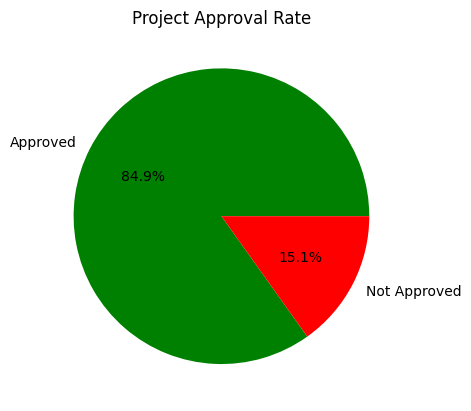

In [19]:
#Write your code here

# Count the number of approved and not approved projects.
approved_count = project_data[project_data['project_is_approved'] == 1].shape[0]
not_approved_count = project_data[project_data['project_is_approved'] == 0].shape[0]
total_projects = project_data.shape[0]

approval_rate = (approved_count / total_projects) * 100
print(f"Approval Rate: {approval_rate:.2f}%")

fig, ax = plt.subplots()
ax.pie([approval_rate, 100 - approval_rate], labels=['Approved', 'Not Approved'], autopct='%1.1f%%', colors=['g', 'r'])
ax.set_title('Project Approval Rate')
plt.show()


**EDA-2**: Analyse the approval rate per state. *You can also plot the approval rates for the top k states*.

In [20]:
def plot_state_approval_rate(approval_rate, title, k=10):
    approval_rate.columns = ['school_state', 'approval_rate']

    # Sort by approval rate and select top k states (with in states with highest approval rate)
    top_k_states = approval_rate.sort_values(by='approval_rate', ascending=False).head(k)

    # Create a bar plot for the approval states
    plt.figure(figsize=(10, 5))
    plt.bar(top_k_states['school_state'], top_k_states['approval_rate'], color = 'skyblue')
    plt.title(title)
    plt.xlabel('School State')
    plt.ylabel('Approval Rate')
    plt.ylim(0, 1)

    #  Adding percentage labels on top of the bars
    for index, row in top_k_states.iterrows():
        plt.text(row['school_state'], row['approval_rate'] + 0.02, f"{row['approval_rate']:.2f}", ha='center')

    plt.show()

/var/folders/8k/p4xbwcxn34x7b1nj4s53zdsw0000gn/T/ipykernel_73917/4198212384.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  states_apporval_rate = project_data.groupby('school_state')['project_is_approved'].mean().reset_index()


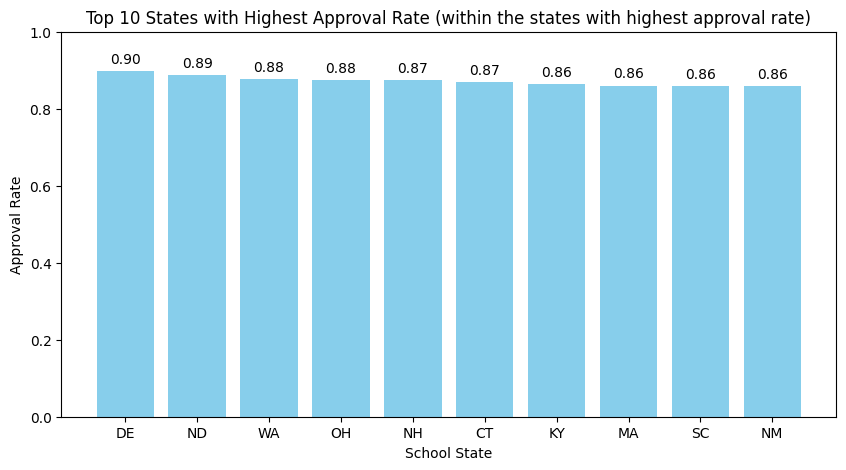

/var/folders/8k/p4xbwcxn34x7b1nj4s53zdsw0000gn/T/ipykernel_73917/4198212384.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  approval_rate = project_data.groupby('school_state')['project_is_approved'].sum().divide(len(project_data)).reset_index()


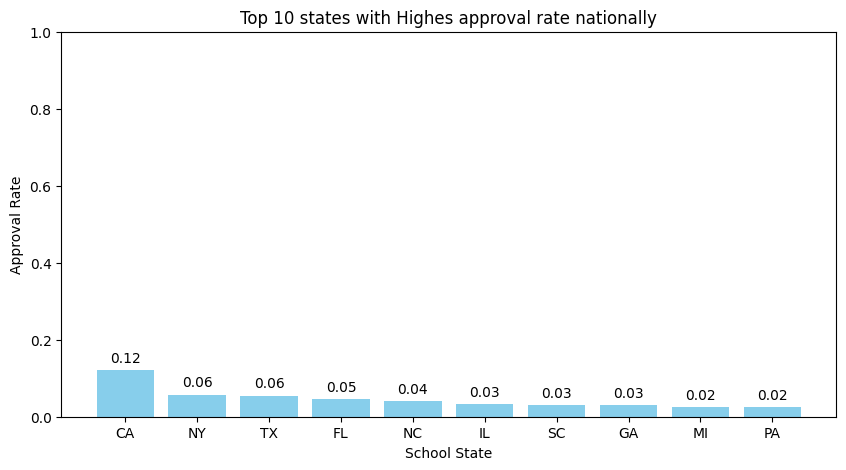

In [21]:
#Write your code here

# Calculate the approval rate per state
states_apporval_rate = project_data.groupby('school_state')['project_is_approved'].mean().reset_index()
title = 'Top 10 States with Highest Approval Rate (within the states with highest approval rate)'
plot_state_approval_rate(states_apporval_rate, title, k=10)


# Calculate the approval rate by state overall (average)
approval_rate = project_data.groupby('school_state')['project_is_approved'].sum().divide(len(project_data)).reset_index()
title = "Top 10 states with Highes approval rate nationally"
plot_state_approval_rate(approval_rate, title, k=10)


**EDA-3**: Analyse the approval rate per project_grade_category using stacked bar chart

/var/folders/8k/p4xbwcxn34x7b1nj4s53zdsw0000gn/T/ipykernel_73917/3202006798.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  approval_rate = project_data.groupby('project_grade_category')['project_is_approved'].mean().reset_index()


  project_grade_category  approval_rate
0           Grades 3-5         0.854377
1           Grades 6-8         0.842522
2          Grades 9-12         0.837636
3        Grades PreK-2         0.848751


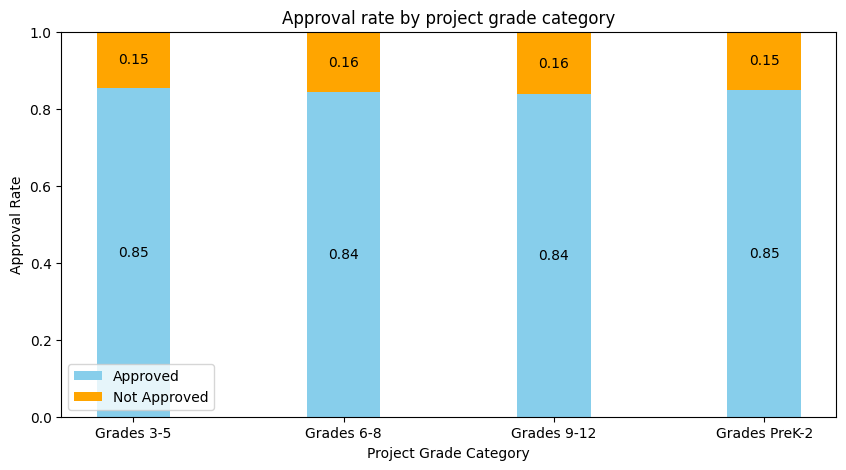

In [22]:
#Write your code here

approval_rate = project_data.groupby('project_grade_category')['project_is_approved'].mean().reset_index()
approval_rate.columns = ['project_grade_category', 'approval_rate']

print(approval_rate)

# Create a bar plot for the approval states
x_cat = np.arange(len(approval_rate['project_grade_category']))
y_approved = approval_rate['approval_rate']
y_not_approved = 1 - approval_rate['approval_rate']
bar_width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x_cat, y_approved, color = 'skyblue', width=bar_width, label='Approved')
plt.bar(x_cat, y_not_approved, color = 'orange', bottom=y_approved, width=bar_width, label='Not Approved')
plt.title("Approval rate by project grade category")
plt.xlabel('Project Grade Category')
plt.ylabel('Approval Rate')
plt.xticks(x_cat, approval_rate['project_grade_category'])
plt.ylim(0, 1)
plt.legend()


#  Adding percentage labels on top of the bars
for index, row in approval_rate.iterrows():
    plt.text(x_cat[index], y_approved[index]/2, f"{row['approval_rate']:.2f}", ha='center', va='center', color='black')
    plt.text(x_cat[index], y_approved[index] + y_not_approved[index]/2, f"{1-row['approval_rate']:.2f}", ha='center', va='center', color='black')


plt.show()

In [23]:
# #Write your code here

# # print(project_data['project_grade_category'].value_counts())
# # print(project_data['project_is_approved'].value_counts()[1])
# # print(project_data.groupby('project_grade_category')['project_is_approved'].sum())

# approval_rate = project_data.groupby('project_grade_category')['project_is_approved'].sum().divide(project_data['project_is_approved'].value_counts()[1]).reset_index()
# approval_rate.columns = ['project_grade_category', 'approval_rate']

# print(approval_rate)

# # Create a bar plot for the approval states

# rates = approval_rate['approval_rate']
# grades = approval_rate['project_grade_category']

# fig, ax = plt.subplots(figsize=(5, 5))
# ax.bar('Grades', rates, label=grades, color = ['skyblue', 'orange', 'lightgreen', 'salmon'])

# ax.bar('Grades', rates, label=grades, color = ['skyblue', 'orange', 'lightgreen', 'salmon'], width=bar_width,)
# ax.set_title("Approval rate by project grade category")
# ax.set_xlabel('Project Grade Category')
# ax.set_ylabel('Approval Rate')
# ax.set_ylim(0, 1)
# ax.legend(grades, loc='upper left')


# #  Adding percentage labels on top of the bars
# # for index, row in approval_rate.iterrows():
# #     plt.text(0, approval_rate[index]/2, f"{row['approval_rate']:.2f}", ha='center', va='center', color='black')

# plt.tight_layout()
# plt.show()

**EDA-4**: Analyse the approval rate per project_subject_categories.
- Is the approval rate same for all categories?
    - **YES** Almost all the categories approval rates fall between 82 to 92%.
- Do all categories have almost equal representation?
    - **No** By count "Literacy & Language" & "Math & Science" has more representation than other categories
- Any skewness observed?
    - **No** with respect to approval rate, there was no skew observed but with respect to representation we have skew on "Literacy & Language" & "Math & Science"

In [24]:
#Write your code here


# subject_category_df = pd.DataFrame(columns=['Category', 'Rate', 'Count'])

def get_subject_categories_rate_count(category):
    rate = project_data[project_data[category] == 1]['project_is_approved'].mean()
    count = project_data[category].sum()
    row_data = pd.DataFrame({'Category': [category], 'Rate': [rate], 'Count': [count]})
    global subject_category_df 
    subject_category_df = pd.concat([subject_category_df, row_data], ignore_index=True)
    return rate, count

if 'project_subject_categories' in project_data.columns:
    project_data['project_subject_categories_split'] = project_data['project_subject_categories'].str.split(', ')
    # print(project_data.head(5))

    df_encoded = project_data['project_subject_categories_split'].str.join('|').str.get_dummies()
    # print(df_encoded.head(5))

    project_data = pd.concat([project_data, df_encoded], axis=1)
    project_data = project_data.drop(columns=['project_subject_categories', 'project_subject_categories_split'])
    print(project_data.head(5))



subject_category_df = pd.DataFrame()

applied_learning_rate, applied_learning_count = get_subject_categories_rate_count('Applied Learning')
care_hunger_rate, care_hunger_count = get_subject_categories_rate_count('Care & Hunger')
health_sports_rate, health_sports_count = get_subject_categories_rate_count('Health & Sports')
History_Civics_rate, History_Civics_count = get_subject_categories_rate_count('History & Civics')
Literacy_Language_rate, Literacy_Language_count = get_subject_categories_rate_count('Literacy & Language')
Math_Science_rate, Math_Science_count = get_subject_categories_rate_count('Math & Science')
Music_TheArts_rate, Music_TheArts_count = get_subject_categories_rate_count('Music & The Arts')
Special_Needs_rate, Special_Needs_count = get_subject_categories_rate_count('Special Needs')
Warmth_rate, Warmth_count = get_subject_categories_rate_count('Warmth')

print(subject_category_df)


   Unnamed: 0 project_id           teacher_id teacher_prefix school_state  \
0      160221    p253737  c90749f5d961ff15...           Mrs.           IN   
1      140945    p258326  897464ce9ddc600b...            Mr.           FL   
2       21895    p182444  3465aaf82da834c0...            Ms.           AZ   
3          45    p246581  f3cb9bffbba169be...           Mrs.           KY   
4      172407    p104768  be1f7507a41f8479...           Mrs.           TX   

  project_submitted_datetime project_grade_category  \
0  2016-12-05 13:43:57              Grades PreK-2     
1  2016-10-25 09:22:10                 Grades 6-8     
2  2016-08-31 12:03:56                 Grades 6-8     
3  2016-10-06 21:16:17              Grades PreK-2     
4  2016-07-11 01:10:09              Grades PreK-2     

  project_subject_subcategories        project_title project_resource_summary  \
0        ESL, Literacy           Educational Supp...  My students need...       
1  Civics & Governm...           Wanted: Pro

**EDA-5**: Is there any gender bias for approval?
  - Use the teacher_prefix column.

  ***No*** - Approval rate among the gender doesn't have any bias, the approval is around 85% approval rate.
  **Note:** Though Approval rate doesn't have any bias, more womens (Mrs, Ms) are applying the projects than Man (Mr) and not prefered category (Dr, Not Prefered, Teacher)

teacher_prefix
Dr.            0.692308
Mr.            0.841473
Mrs.           0.855559
Ms.            0.843537
NotPrefered    1.000000
Teacher        0.795339
Name: project_is_approved, dtype: float64


/var/folders/8k/p4xbwcxn34x7b1nj4s53zdsw0000gn/T/ipykernel_73917/3045687874.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(project_data.groupby('teacher_prefix')['project_is_approved'].mean())
/var/folders/8k/p4xbwcxn34x7b1nj4s53zdsw0000gn/T/ipykernel_73917/3045687874.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  approval_rate = project_data.groupby('teacher_prefix')['project_is_approved'].mean().reset_index()


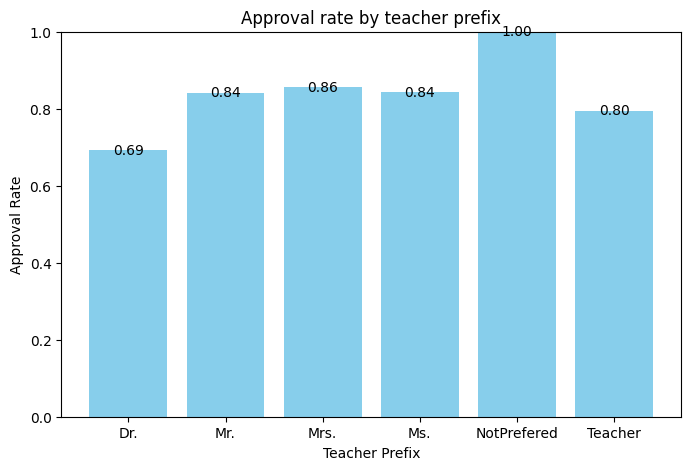

In [25]:
#Write your code here
print(project_data.groupby('teacher_prefix')['project_is_approved'].mean())
approval_rate = project_data.groupby('teacher_prefix')['project_is_approved'].mean().reset_index()
approval_rate.columns = ['teacher_prefix', 'approval_rate']

plt.figure(figsize=(8, 5))
plt.title("Approval rate by teacher prefix")
plt.xlabel('Teacher Prefix')
plt.ylabel('Approval Rate')
plt.ylim(0, 1)

plt.bar(approval_rate['teacher_prefix'], approval_rate['approval_rate'], color = 'skyblue')

for index, row in approval_rate.iterrows():
    plt.text(index, row['approval_rate'], f"{row['approval_rate']:.2f}", ha='center', va='center', color='black')

plt.show()

**EDA-6**: Check whether the approval rate depends on the amount and quantity of the resources?
- Provide descriptive statstics for approved & not-approved projects.
- with appropriate visualizations for a better understanding of the results

**Approval rate doesn't depend on cost or quantity, but in general mean and median of the project total cost and quantity of both approved and not approved projects don't have high variation**

Approved Data: 
       total_quantity   total_price
count    92706.000000  92706.000000
mean        16.390223    537.489913
std         25.592556    543.081743
min          1.000000    100.000000
25%          3.000000    240.482500
50%          8.000000    391.440000
75%         20.000000    679.080000
max        930.000000  13543.820000


Not Approved Data: 
       total_quantity   total_price
count    16542.000000  16542.000000
mean        20.190243    590.922012
std         29.062878    565.254646
min          1.000000    100.000000
25%          6.000000    273.905000
50%         12.000000    428.360000
75%         24.000000    734.887500
max        808.000000  10987.060000


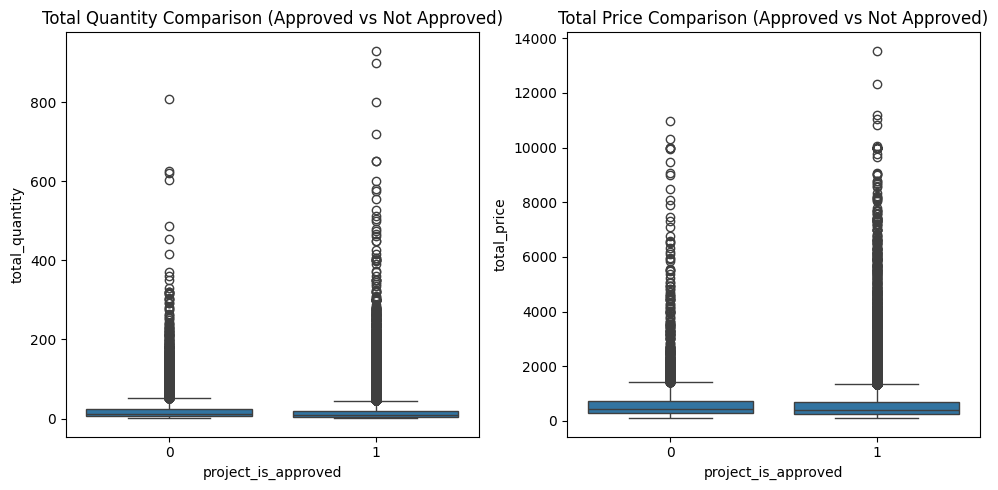

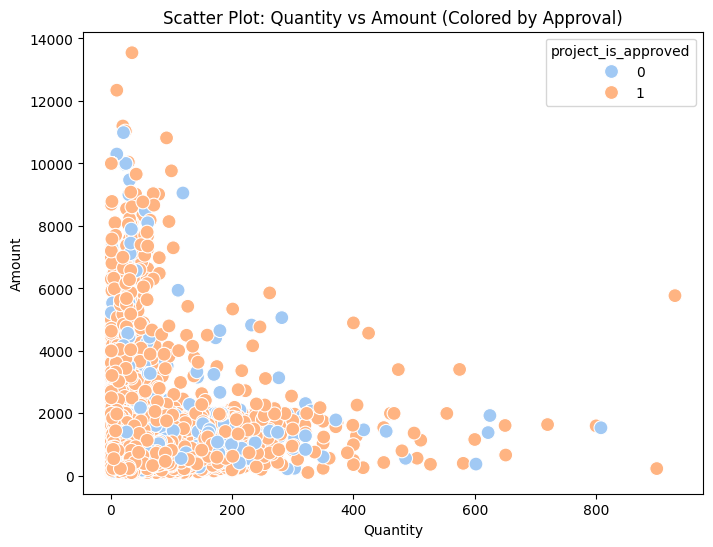

In [26]:
## Write code for additional analysis here

# Provide descriptive statistics of approved and not-approved projects by amount and quantity of the resources
approved_df = project_data[project_data['project_is_approved'] == 1]
not_approved_df = project_data[project_data['project_is_approved'] == 0]

print(f"Approved Data: \n{approved_df[["total_quantity", "total_price"]].describe()}\n\n")
print(f"Not Approved Data: \n{not_approved_df[["total_quantity", "total_price"]].describe()}")

# Create a boxplot for quantity comparison
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='project_is_approved', y='total_quantity', data=project_data)
plt.title('Total Quantity Comparison (Approved vs Not Approved)')

# Create a boxplot for amount comparison
plt.subplot(1, 2, 2)
sns.boxplot(x='project_is_approved', y='total_price', data=project_data)
plt.title('Total Price Comparison (Approved vs Not Approved)')

plt.tight_layout()
plt.show()

# Scatter plot for quantity vs amount, colored by approval status
plt.figure(figsize=(8, 6))
sns.scatterplot(x='total_quantity', y='total_price', hue='project_is_approved', data=project_data, palette='pastel', s=100)
plt.title('Scatter Plot: Quantity vs Amount (Colored by Approval)')
plt.xlabel('Quantity')
plt.ylabel('Amount')
plt.show()

**EDA-7**: Conduct further analysis to uncover patterns, anomalies, and relationships within the data.
- Summary statistics
- Distribution plots
- Correlation matrix (for numerical features)
- how approval rate changes across the different features

In [27]:
## Write code for additional analysis here
project_data.describe()

,Unnamed: 0,project_submitted_datetime,teacher_number_of_previously_posted_projects,project_is_approved,total_quantity,total_price,Applied Learning,Care & Hunger,Health & Sports,History & Civics,Literacy & Language,Math & Science,Music & The Arts,Special Needs,Warmth
count,109248.000000,109248,109248.000000,109248.000000,109248.000000,109248.000000,109248.000000,109248.000000,109248.000000,109248.000000,109248.000000,109248.000000,109248.000000,109248.000000,109248.000000
mean,91183.786568,2016-10-21 13:26...,11.153165,0.848583,16.965610,545.580439,0.111078,0.012705,0.130190,0.054134,0.478169,0.379147,0.094217,0.124872,0.012705
min,0.000000,2016-04-27 00:27:36,0.000000,0.000000,1.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,45743.500000,2016-08-10 19:47...,0.000000,1.000000,4.000000,245.917500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,91253.500000,2016-09-30 12:51...,2.000000,1.000000,9.000000,397.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,136712.500000,2017-01-11 00:08...,9.000000,1.000000,21.000000,691.552500,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,182079.000000,2017-04-30 23:45:08,451.000000,1.000000,930.000000,13543.820000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,52548.095272,NaN,27.777154,0.358456,26.182942,546.829779,0.314230,0.111999,0.336514,0.226282,0.499525,0.485177,0.292131,0.330575,0.111999


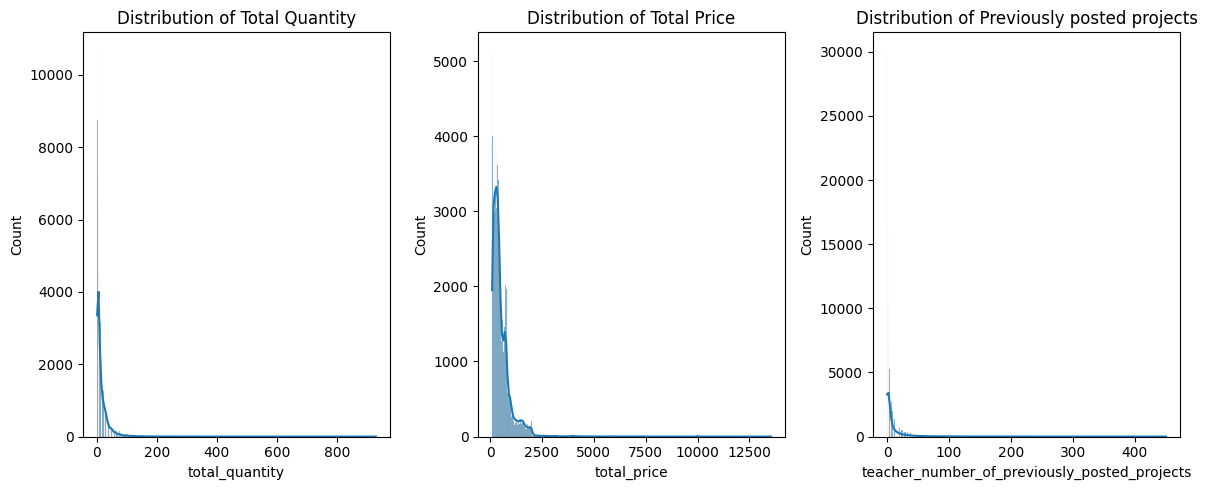

In [28]:
## Write code for additional analysis here

# Distribution plot for quantity
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
sns.histplot(project_data['total_quantity'], kde=True)
plt.title("Distribution of Total Quantity")

# Distribution plot for amount
plt.subplot(1, 3, 2)
sns.histplot(project_data['total_price'], kde=True)
plt.title("Distribution of Total Price")

# teacher who has previously posted projects
plt.subplot(1, 3, 3)
sns.histplot(project_data['teacher_number_of_previously_posted_projects'], kde=True)
plt.title("Distribution of Previously posted projects")

plt.tight_layout()
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109248 entries, 0 to 109247
Data columns (total 24 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   Unnamed: 0                                    109248 non-null  int64         
 1   project_id                                    109248 non-null  object        
 2   teacher_id                                    109248 non-null  object        
 3   teacher_prefix                                109248 non-null  category      
 4   school_state                                  109248 non-null  category      
 5   project_submitted_datetime                    109248 non-null  datetime64[ns]
 6   project_grade_category                        109248 non-null  category      
 7   project_subject_subcategories                 109248 non-null  category      
 8   project_title                                 109248 n

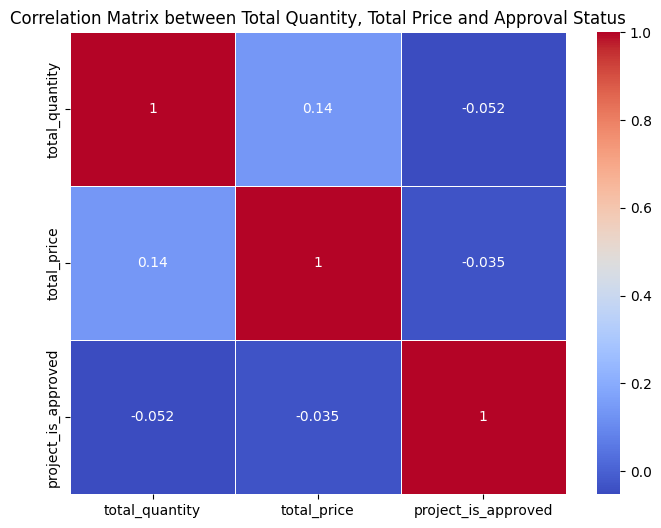

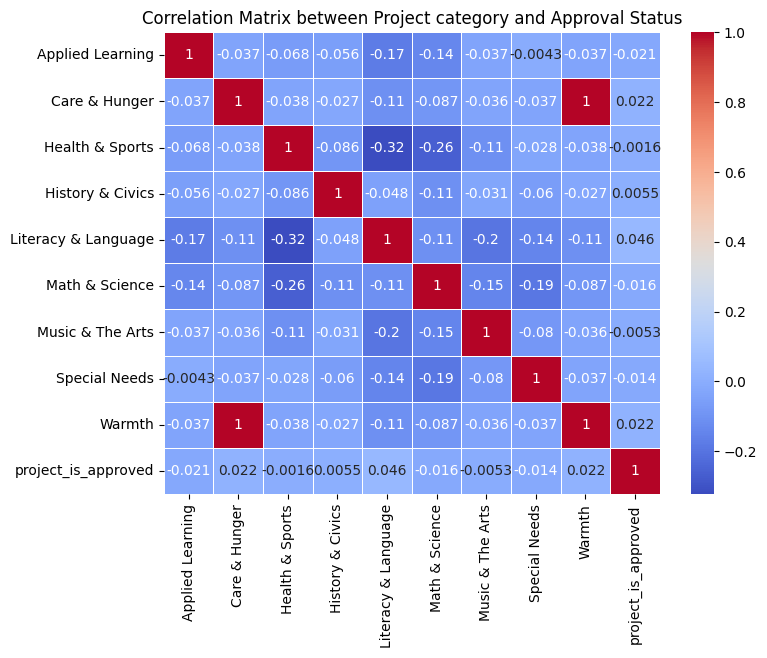

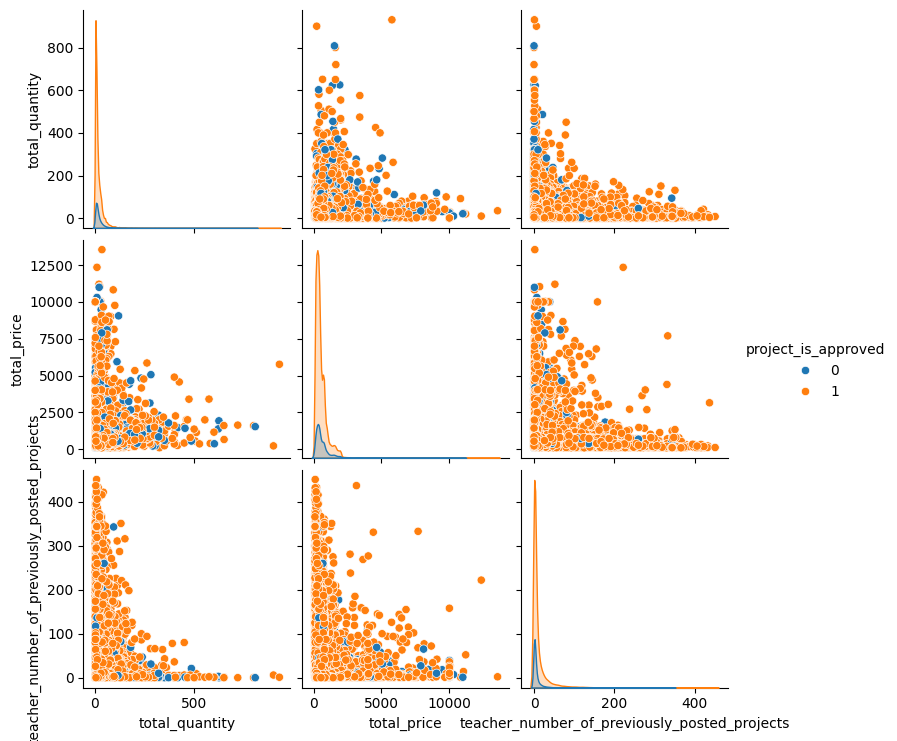

In [29]:
## Write code for additional analysis here

print(project_data.info())
# Correlation matrix between quantity, amount and approval
corr_matrix = project_data[['total_quantity', 'total_price', 'project_is_approved']].corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix between Total Quantity, Total Price and Approval Status")
plt.show()

# Correlation matrix between subject category and approval
corr_matrix = project_data[['Applied Learning', 'Care & Hunger', 'Health & Sports', 'History & Civics', 'Literacy & Language', 'Math & Science', 'Music & The Arts', 'Special Needs', 'Warmth','project_is_approved']].corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix between Project category and Approval Status")
plt.show()


# Pair plot to explore relationships between numerical variables and approved status
sns.pairplot(project_data[['total_quantity', 'total_price', 'teacher_number_of_previously_posted_projects', 'project_is_approved']], hue='project_is_approved', diag_kind='kde')
plt.show()

**Observations**

Document all the insights you get from EDA here

- Teachers who posted the project previously tend to raise project with less quantity and more price were approved.
- "Literacy & Language", "Maths & Science" subject category requests for more project support compared to others subjects
- There is no strong corelation between approval rate to total price and total quantity.
- Total price and Total quantity requested doesn't has more outliers, spread is more.

***Checklist***

Before proceeding further, check
- the overall approval rate is analyzed and visualized
- the approval rate is analyzed vs different other features both categorical and numeric
- if you created any new columns here for analysis, once again check the dataframe to inspect

In [30]:
## Write the code to perform any necessary sanity checks before proceeding further

With this the EDA section is now complete. Now, let's proceed to the next section on preparing the data for model building later

## Pre-Modelling Data Preparation

There are 5 steps to be done before we proceed to model building

- Handle the class imbalance in the data
- Text Pre-Processing for raw text columns
- Feature Encoding (One-hot encoding, etc.) for categorical columns
- Scaling (Standardization, Normalization, etc.) for numeric columns
- train-test-validation split

**Handling Class Imbalance**

As per the target variable distribution seen earlier, the datapoints for class "0" (not approved) is much low when compared with class "1" (approved).
This may lead to the model learning more than "1" class as compared to "0" class. Also the number of records are huge - 100k. You can follow these steps:

  - **Undersampling**: Reduce the data imbalance by selecting all instances from the minority class (class "0") and randomly selecting an equal number of instances from the majority class (class "1").

  - **Oversampling**: Increase the representation of the minority class by techniques like Random Oversampling or SMOTE to balance the dataset.

Choosing the appropriate method is crucial. It depends on various factors and the specific requirements of your model.As the number of columns would increase significantly once we start using text processing, it is imperative to take a pragmatic decision here.

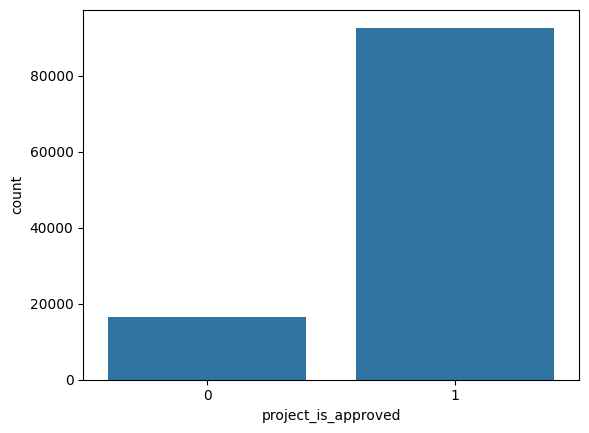

In [31]:
### Write the code for handling class imbalance here

# Identify whether the class is imbalanced?
sns.countplot(x='project_is_approved', data=project_data)
plt.show()

# YES the class is imbalanced, hence 

Once you have performed the necessary steps, it's time to move to the feature encoding part

**Feature Encoding (One-hot encoding, etc.) for categorical columns**

In [32]:
from sklearn.preprocessing import LabelEncoder

# Create a copy of project_data
proj_data = project_data.copy()

# Drop the project_id column, whichi is not needed
proj_data = proj_data.drop('project_id', axis=1)

# Use Frequency encoding for teacher_id
proj_data['teacher_id'] = proj_data['teacher_id'].map(proj_data['teacher_id'].value_counts().to_dict())

# Use one hot encoding for teacher prefix
proj_data = pd.get_dummies(proj_data, columns=['teacher_prefix'], prefix='TP', prefix_sep='')

# Use one hot encoding for school state
proj_data = pd.get_dummies(proj_data, columns=['school_state'], prefix='SS', prefix_sep='')

# Use Label encoding for project_grade_category
label_encoder_4_proj_cat = LabelEncoder()
proj_data['project_grade_category'] = label_encoder_4_proj_cat.fit_transform(proj_data['project_grade_category'])

# Merge all the text into one
if 'project_title' in project_data.columns:
    # proj_data['project_title_essay_summary'] = proj_data['project_title'].str.lower() + ' ' + proj_data['project_resource_summary'].str.lower() + ' ' + proj_data['project_essay'].str.lower()
    proj_data['project_title_essay_summary'] = proj_data[['project_title', 'project_resource_summary', 'project_essay']].apply(lambda x: ' '.join(x.dropna()), axis=1)
    proj_data['project_title_essay_summary'] = proj_data['project_title_essay_summary'].str.lower()
    proj_data = proj_data.drop(columns=['project_title', 'project_resource_summary', 'project_essay'])

# One hot encoding of project_subject_sub_categories
if 'project_subject_subcategories' in proj_data.columns:
    proj_data['project_subject_subcategories_split'] = proj_data['project_subject_subcategories'].str.split(', ')
    # proj_data['proj_subject_subcat_split_count'] = proj_data['project_subject_subcategories_split'].apply(lambda x: len(x))
    # print(proj_data.head(5))
    df_encoded = proj_data['project_subject_subcategories_split'].str.join('|').str.get_dummies()
    proj_data = pd.concat([proj_data, df_encoded], axis=1)
    proj_data = proj_data.drop(columns=['project_subject_subcategories', 'project_subject_subcategories_split'])

print(proj_data.info())
print(proj_data.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109248 entries, 0 to 109247
Columns: 105 entries, Unnamed: 0 to Warmth
dtypes: bool(57), datetime64[ns](1), float64(1), int64(45), object(1)
memory usage: 45.9+ MB
None
   Unnamed: 0  teacher_id project_submitted_datetime  project_grade_category  \
0      160221           1  2016-12-05 13:43:57                          3      
1      140945           4  2016-10-25 09:22:10                          1      
2       21895           3  2016-08-31 12:03:56                          1      
3          45           2  2016-10-06 21:16:17                          3      
4      172407           1  2016-07-11 01:10:09                          3      

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                    0                                             0   
1                    7                                             1   
2                    1                                             0   
3           

In [33]:
### Inspect the new dataframe and see if it looks okay

# Import necessary libraries
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

rand_state = 42

# Example splitting features (X) and target (y)
X = proj_data.drop('project_is_approved', axis=1)
y = proj_data['project_is_approved']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rand_state)

# Apply RandomUnderSampler
undersampler = RandomUnderSampler(random_state=rand_state)
X_resampled_u, y_resampled_u = undersampler.fit_resample(X_train, y_train)

# Apply RandomOverSampler
oversampler = RandomOverSampler(random_state=rand_state)
X_resampled_o, y_resampled_o = oversampler.fit_resample(X_train, y_train)

# Check the distribution after undersampling
print("Before resampling: ", y_train.value_counts())
print("After undersampling: ", pd.Series(y_resampled_u).value_counts())
print("After oversampling: ", pd.Series(y_resampled_o).value_counts())

Before resampling:  project_is_approved
1    64989
0    11484
Name: count, dtype: int64
After undersampling:  project_is_approved
0    11484
1    11484
Name: count, dtype: int64
After oversampling:  project_is_approved
1    64989
0    64989
Name: count, dtype: int64


In [34]:
# # Import necessary libraries
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, confusion_matrix

# # Train the model using the resampled data
# model = RandomForestClassifier(random_state=rand_state)
# model.fit(X_resampled_u, y_resampled_u)

# # Test the model on the original test set
# y_pred = model.predict(X_test)

# # Evaluate the performance
# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))

**Text-Processing**

There are two steps to be performed here

- Text Cleaning
- Conversion of text features to numeric features

***Text Cleaning***

Raw text often presents several challenges. Some of them include:

- **Noise and Irrelevant Information**: Raw text can include extraneous information that may not be useful for analysis or modeling.

- **Inconsistent Formatting**: Text data can vary in format, which makes it difficult to standardize and process.

- **Spelling and Grammar Errors**: Errors in spelling, grammar, and punctuation can affect the quality of text analysis and processing.

- **High Dimensionality**: Text data can be high-dimensional due to the large number of unique words or terms, complicating analysis and modeling.

- **Language Variability**: Variations in language usage, slang, or domain-specific terminology can impact the consistency and effectiveness of text analysis.


- Let's clean the text to improve the quality of data
  
  - Decontracting text, removing escape sequences, special characters and stop words

  - You can use two popular libraries to handle text data.
    1. Natural Language ToolKit (nltk)
    2. Regular Expressions (re)

To help you prepare your text for analysis, we have included some basic functions for cleaning and normalization. Use these functions as a starting point and tailor them to achieve optimal text quality.

In [35]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import re
import nltk
from textblob import TextBlob

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

stemmer = SnowballStemmer(language='english')

def stem_sentence(text):
    word_tokens = word_tokenize(text)  # Tokenize the text
    stemmed_tokens = [stemmer.stem(token) for token in word_tokens]  # Apply stemming
    text = ' '.join(stemmed_tokens)  # Join the stemmed words back into a sentence
    return text

# Decontracting text involves expanding contractions into their full forms.
def decontract_text(text):

    # decontract text

    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)

    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)

    return text

# Escape sequences are special character combinations used to represent characters that cannot be directly represented.
# These often need to be removed for text processing.

def remove_escape_sequences(text):

    # remove escape sequences

    text = text.replace('\\r', ' ')
    text = text.replace('\\"', ' ')
    text = text.replace('\\n', ' ')

    return text


# Remove special characters using regular expressions.
# Special characters are characters that are not letters or numbers.
# These often include punctuation, symbols, and control characters.

def remove_special_characters(text):
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    return text

def correct_spelling(text):
    text = str(TextBlob(text).correct())
    return text

# Stop words are common words that often carry little semantic meaning (e.g., "the," "and," "is").
# Removing them can help focus on the more important words in the text.
def remove_stop_words(text):

        stop_words = set(stopwords.words('english'))
        word_tokens = word_tokenize(text)
        filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
        #with no lower case conversion
        filtered_sentence = []
        for w in word_tokens:
                if w not in stop_words:
                        filtered_sentence.append(w)
        text = ' '.join(filtered_sentence)
        return text


def preprocess_text(text):

  text = text.lower().strip()
  text = decontract_text(text)
  text = remove_escape_sequences(text)
  text = remove_special_characters(text)
  text = remove_stop_words(text)
  # text = correct_spelling(text)
  text = stem_sentence(text)

  return text.lower().strip()

[nltk_data] Downloading package stopwords to /Users/pandi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/pandi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/pandi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [36]:
for txt in proj_data['project_title_essay_summary'].head(1):
  print(f"Before preprocessing: {type(txt)}{txt},")
  print(f"After Processing: {preprocess_text(txt)}")

Before preprocessing: <class 'str'>educational support for english learners at home my students need opportunities to practice beginning reading skills in english at home. my students are english learners that are working on english as their second or third languages. we are a melting pot of refugees, immigrants, and native-born americans bringing the gift of language to our school. \r\n\r\n we have over 24 languages represented in our english learner program with students at every level of mastery.  we also have over 40 countries represented with the families within our school.  each student brings a wealth of knowledge and experiences to us that open our eyes to new cultures, beliefs, and respect.\"the limits of your language are the limits of your world.\"-ludwig wittgenstein  our english learner's have a strong support system at home that begs for more resources.  many times our parents are learning to read and speak english along side of their children.  sometimes this creates bar

In [37]:
# Perform text cleaning steps on your text_columns
# Type your code here
pd.set_option('display.max_columns', None)
proj_data['project_title_essay_summary_cleaned'] = proj_data['project_title_essay_summary'].apply(lambda x: preprocess_text(x))
# proj_data.drop(columns=['project_title_essay_summary'], inplace=True)
proj_data.info(verbose=True)
proj_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109248 entries, 0 to 109247
Data columns (total 106 columns):
 #    Column                                        Dtype         
---   ------                                        -----         
 0    Unnamed: 0                                    int64         
 1    teacher_id                                    int64         
 2    project_submitted_datetime                    datetime64[ns]
 3    project_grade_category                        int64         
 4    teacher_number_of_previously_posted_projects  int64         
 5    project_is_approved                           int64         
 6    total_quantity                                int64         
 7    total_price                                   float64       
 8    Applied Learning                              int64         
 9    Care & Hunger                                 int64         
 10   Health & Sports                               int64         
 11   History & C

,Unnamed: 0,teacher_id,project_submitted_datetime,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,total_quantity,total_price,Applied Learning,Care & Hunger,Health & Sports,History & Civics,Literacy & Language,Math & Science,Music & The Arts,Special Needs,Warmth,TPDr.,TPMr.,TPMrs.,TPMs.,TPNotPrefered,TPTeacher,SSAK,SSAL,SSAR,SSAZ,SSCA,SSCO,SSCT,SSDC,SSDE,SSFL,SSGA,SSHI,SSIA,SSID,SSIL,SSIN,SSKS,SSKY,SSLA,SSMA,SSMD,SSME,SSMI,SSMN,SSMO,SSMS,SSMT,SSNC,SSND,SSNE,SSNH,SSNJ,SSNM,SSNV,SSNY,SSOH,SSOK,SSOR,SSPA,SSRI,SSSC,SSSD,SSTN,SSTX,SSUT,SSVA,SSVT,SSWA,SSWI,SSWV,SSWY,project_title_essay_summary,Applied Sciences,Care & Hunger,Character Education,Civics & Government,College & Career Prep,Community Service,ESL,Early Development,Economics,Environmental Science,Extracurricular,Financial Literacy,Foreign Languages,Gym & Fitness,Health & Life Science,Health & Wellness,History & Geography,Literacy,Literature & Writing,Mathematics,Music,Nutrition Education,Other,Parent Involvement,Performing Arts,Social Sciences,Special Needs,Team Sports,Visual Arts,Warmth,project_title_essay_summary_cleaned
0,160221,1,2016-12-05 13:43:57,3,0,0,23,596.36,0,0,0,0,1,0,0,0,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,educational supp...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,educ support eng...
1,140945,4,2016-10-25 09:22:10,1,7,1,1,299.00,0,0,1,1,0,0,0,0,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,wanted: projecto...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,want projector h...
2,21895,3,2016-08-31 12:03:56,1,1,0,22,686.68,0,0,1,0,0,0,0,0,0,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,soccer equipment...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,soccer equip awe...
3,45,2,2016-10-06 21:16:17,3,4,1,4,431.90,0,0,0,0,1,1,0,0,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,techie kindergar...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,techi kindergart...
4,172407,1,2016-07-11 01:10:09,3,1,1,4,143.96,0,0,0,0,0,1,0,0,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,interactive math...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,interact math to...


In [38]:
## Check the dataframe and see if the columns are cleaned or not
pd.set_option('display.max_columns', None)
proj_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109248 entries, 0 to 109247
Data columns (total 106 columns):
 #    Column                                        Dtype         
---   ------                                        -----         
 0    Unnamed: 0                                    int64         
 1    teacher_id                                    int64         
 2    project_submitted_datetime                    datetime64[ns]
 3    project_grade_category                        int64         
 4    teacher_number_of_previously_posted_projects  int64         
 5    project_is_approved                           int64         
 6    total_quantity                                int64         
 7    total_price                                   float64       
 8    Applied Learning                              int64         
 9    Care & Hunger                                 int64         
 10   Health & Sports                               int64         
 11   History & C

Feel free to exlore other Python libraries that can help you improve the text quality.

---

***Conversion of text features to numeric features***

- Machine Learning models can't work on plain English text. We need to convert this text into a structured format with numbers.

  - How can we turn text into numbers? This is where the Bag of Words method comes in. In BoW, each text feature (like a sentence or paragraph) is treated as a collection of words.
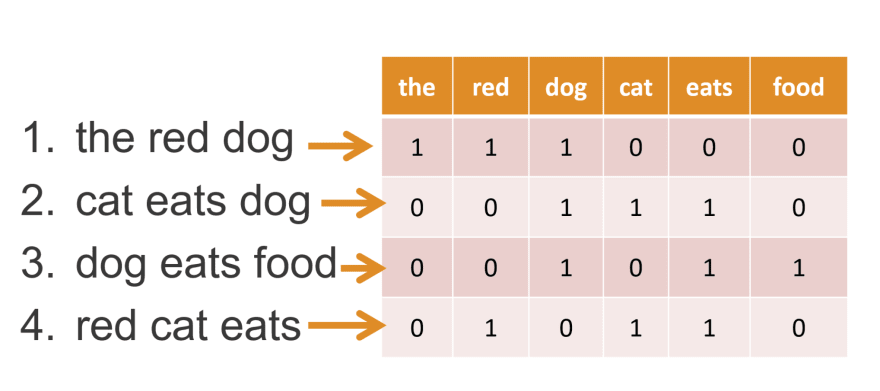

- **Creating the Vocabulary**:
  - The BoW model will first create a list of all unique words across all your text features.

- **Counting Word Frequencies**:
  - For each text feature, the BoW model counts the occurrences of each word from the vocabulary.

- **Building Feature Vectors**:
  - These word counts are then used to build feature vectors for each text feature, which can be used as input for your machine learning models.




In [39]:
## Steps to perform a bag of words model

# Import necessary library
# Use sklearn.feature_extraction.text for the CountVectorizer class.
# Your code here
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Instantiate a CountVectorizer Object
# Use the fit_transform method on your text data.
# This creates a document-term matrix where rows represent documents and columns represent words.
cv = CountVectorizer()
X = cv.fit_transform(proj_data['project_title_essay_summary_cleaned'])
# X_df = pd.DataFrame(vectorizer.fit_transform(proj_data['project_title_essay_summary_cleaned']).todense(), columns=sorted(vectorizer.vocabulary))

# The output is a sparse matrix. You can convert it to a dense matrix or DataFrame for easier manipulation.
cv_df = pd.DataFrame(X.toarray(), columns=cv.get_feature_names_out())

print(cv_df.shape)
print(cv_df.info())

# Instantiate a TfidfVectorizer Object try with maximum feature as 10K
# Use the fit_transform method on your text data.
# This creates a document-term matrix where rows represent documents and columns represent words.
# The output is a sparse matrix. You can convert it to a dense matrix or DataFrame for easier manipulation.
tf_idf = TfidfVectorizer(max_features=5000)
tfidf_matrix = tf_idf.fit_transform(proj_data['project_title_essay_summary_cleaned'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tf_idf.get_feature_names_out())

print(f"tfidf shape: {tfidf_df.shape}")
print(f"tfidf info: {tfidf_df.info()}")



(109248, 41453)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109248 entries, 0 to 109247
Columns: 41453 entries, 00 to zzzzzzz
dtypes: int64(41453)
memory usage: 33.7 GB
None
tfidf shape: (109248, 5000)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109248 entries, 0 to 109247
Columns: 5000 entries, 00 to zoom
dtypes: float64(5000)
memory usage: 4.1 GB
tfidf info: None


tfidf shape: (109248, 5000)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109248 entries, 0 to 109247
Columns: 5000 entries, 00 to zoom
dtypes: float64(5000)
memory usage: 4.1 GB
tfidf info: None


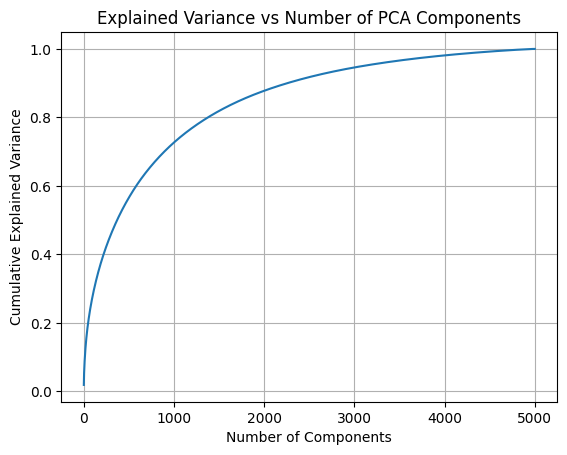

Number of components to retain 95% variance: 3089
Reduced Document-Term Matrix (PCA):
            0         1         2         3         4         5         6     \
0       0.087025 -0.038632 -0.016256  0.002681  0.039349 -0.024122 -0.027990   
1      -0.033729 -0.083150  0.004592 -0.036770 -0.005318 -0.033399 -0.015437   
2      -0.037348 -0.069311 -0.127060 -0.006816  0.100023  0.021547 -0.125423   
3       0.026533 -0.113481  0.185921  0.091651  0.235611 -0.033680  0.157867   
4      -0.026719 -0.076902 -0.020159  0.146143  0.002299 -0.021849 -0.082172   
...          ...       ...       ...       ...       ...       ...       ...   
109243 -0.040923 -0.009494 -0.050566 -0.037204 -0.003807 -0.050936 -0.020780   
109244 -0.036271 -0.198046  0.306397 -0.105355  0.117971 -0.017205  0.177005   
109245  0.020406  0.026275 -0.032125  0.019237  0.015447 -0.016302 -0.016941   
109246 -0.259909  0.251605  0.116884 -0.033056 -0.046589  0.015280  0.046909   
109247 -0.017868 -0.138875  0.0253

In [40]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the 'project_title_essay_summary_cleaned' column to create the document-term matrix (sparse)
X = vectorizer.fit_transform(proj_data['project_title_essay_summary_cleaned'])

# Convert the sparse matrix to a dense matrix (NumPy array)
X_dense = X.toarray()

# Convert the dense matrix to a pandas DataFrame for easier manipulation
dtm_df = pd.DataFrame(X_dense, columns=vectorizer.get_feature_names_out())

print(f"tfidf shape: {dtm_df.shape}")
print(f"tfidf info: {dtm_df.info()}")

# Apply PCA for dimensionality reduction
# Initialize PCA, initially with more components than needed
pca = PCA(n_components=dtm_df.shape[1])  # Use as many components as the number of columns initially
X_pca = pca.fit_transform(dtm_df)

# Plot the cumulative explained variance to identify the number of components to retain 95% variance
explained_variance = pca.explained_variance_ratio_.cumsum()

plt.plot(explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of PCA Components')
plt.grid(True)
plt.show()

# Select the top-k components that preserve ~95% of the variance
n_components_95 = next(i for i, cum_var in enumerate(explained_variance) if cum_var >= 0.95)
print(f"Number of components to retain 95% variance: {n_components_95}")

# Apply PCA again with the selected number of components
pca = PCA(n_components=n_components_95)
X_reduced = pca.fit_transform(dtm_df)

# Convert the reduced PCA result to a DataFrame for easier use
pca_df = pd.DataFrame(X_reduced)
print("Reduced Document-Term Matrix (PCA):")
print(pca_df)

In [41]:
## Inspect the dataframe once again

proj_data.drop(columns=['project_title_essay_summary'], inplace=True)
proj_data.drop(columns=['project_title_essay_summary_cleaned'], inplace=True)
proj_data = pd.concat([pca_df, proj_data], axis=1)

print(proj_data.shape)
print(proj_data.info())
# print(proj_data.head(5))


(109248, 3193)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109248 entries, 0 to 109247
Columns: 3193 entries, 0 to Warmth
dtypes: bool(57), datetime64[ns](1), float64(3090), int64(45)
memory usage: 2.6 GB
None


Once you have performed the necessary steps, it's time to move to feature scaling part

**Scaling (Standardization, Normalization, etc.) for numeric columns**
- Before the ML modelling part, ensure all the numeric features are scaled properly

In [42]:
## Write the code for scaling the numeric features of the dataset
from sklearn.preprocessing import MinMaxScaler

# Assuming df is your DataFrame
# Convert all column names to strings
proj_data.columns = proj_data.columns.astype(str)

# Convert datetime columns to timestamps or extract features
proj_data['project_submitted_datetime'] = pd.to_datetime(proj_data['project_submitted_datetime'])  # Ensure it's in datetime format
proj_data['year'] = proj_data['project_submitted_datetime'].dt.year  # Extract year
proj_data['month'] = proj_data['project_submitted_datetime'].dt.month  # Extract month
proj_data['day'] = proj_data['project_submitted_datetime'].dt.day  # Extract day
# Drop the original datetime column if no longer needed
proj_data.drop(columns=['project_submitted_datetime'], inplace=True)

# Select numeric columns (float, int, and bool can be treated as int)
numeric_cols = proj_data.select_dtypes(include=['float64', 'int64', 'bool']).columns

# Initialize the scaler (StandardScaler for z-score scaling)
scaler = MinMaxScaler()

# Apply scaling only to numeric columns
proj_data[numeric_cols] = scaler.fit_transform(proj_data[numeric_cols])

# Check the result of scaled DataFrame
print(proj_data.shape)
print(proj_data.info())
print(proj_data.head())


(109248, 3195)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109248 entries, 0 to 109247
Columns: 3195 entries, 0 to day
dtypes: float64(3192), int32(3)
memory usage: 2.6 GB
None
          0         1         2         3         4         5         6  \
0  0.484564  0.329451  0.346980  0.439819  0.392384  0.416174  0.312617   
1  0.363805  0.272530  0.375755  0.386137  0.335019  0.404171  0.328052   
2  0.360187  0.290224  0.194045  0.426896  0.470307  0.475260  0.192814   
3  0.424071  0.233748  0.626029  0.560883  0.644439  0.403809  0.541146   
4  0.370816  0.280519  0.341592  0.635032  0.344801  0.419115  0.245995   

          7         8         9        10        11        12        13  \
0  0.353364  0.277913  0.337677  0.694052  0.296623  0.419995  0.455202   
1  0.306614  0.524194  0.325901  0.593708  0.425656  0.465043  0.414367   
2  0.217810  0.485114  0.443180  0.588289  0.206053  0.608957  0.502694   
3  0.228950  0.530403  0.396730  0.657069  0.389692  0.530549  0.3

Once you have performed the necessary steps, let's combine all the features to create the X and y variables

**train-test-validation split**

In [43]:
# Concatenate all the final features [BoW, numeric, and one-hot encoded categorical features] as your input X

# Example splitting features (X) and target (y)
X = proj_data.drop('project_is_approved', axis=1)
y = proj_data['project_is_approved']


Let's split the combined dataframe into the following partitions: `train`, `validation`, and `test`.

In [44]:
## Write the code to split the dataset here
## Chose around 60-80% as training 10-20% test and 10-20% validation

# Split data into train+val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split train+val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
# test_size=0.25 makes validation 20% of the original data, and training 60% (75% of the remaining 80%).

# Step 3: Check the sizes of each split
print(f"Training set size: {len(X_train)} ({len(X_train) / len(X):.2%})")
print(f"Validation set size: {len(X_val)} ({len(X_val) / len(X):.2%})")
print(f"Test set size: {len(X_test)} ({len(X_test) / len(X):.2%})")


Training set size: 65548 (60.00%)
Validation set size: 21850 (20.00%)
Test set size: 21850 (20.00%)


Once the train-test-validation split is done, it's time to move on to the model building part

## Model Building

#### Very Important

Ensure that you have only taken a sample of the entire dataset for building the first few models. Or else the number of columns and rows would be too huge for you to run and it may take hours to train.

- Start off with 20% of the original dataset.
- Perform the model building and evaluation steps on the same.
- Once you have obtained decent results, document those and then scale the datapoints based on the results that you're getting.


Note - Model Building and Model Evaluation sometimes happen together for identifying the best models. Hence then next two sections can be considered as a single large section and you can complete them together

Your goal is to build a classification model that is able to identify which projects get approved. For this, build at least 2 classifcation models to compare and contrast

In [45]:
# Choose an appropriate machine learning model for classification.
# You can start with logistic regression.
# Your code here

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Assume X_train, X_val, y_train, y_val, X_test, y_test are already split

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)  # Increase max_iter if convergence warnings appear
log_reg.fit(X_train, y_train)

# Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_log_reg = log_reg.predict(X_val)
y_pred_rf = rf_clf.predict(X_val)

# Evaluate both models
# Logistic Regression Performance
log_reg_acc = accuracy_score(y_val, y_pred_log_reg)
print(f"Logistic Regression Accuracy: {log_reg_acc:.4f}")
print("Logistic Regression Classification Report:")
print(classification_report(y_val, y_pred_log_reg))

# Random Forest Performance
rf_acc = accuracy_score(y_val, y_pred_rf)
print(f"Random Forest Accuracy: {rf_acc:.4f}")
print("Random Forest Classification Report:")
print(classification_report(y_val, y_pred_rf))

# Step 5: Compare models on test data (if desired)
y_test_pred_log_reg = log_reg.predict(X_test)
y_test_pred_rf = rf_clf.predict(X_test)

print(f"Test Accuracy Logistic Regression: {accuracy_score(y_test, y_test_pred_log_reg):.4f}")
print(f"Test Accuracy Random Forest: {accuracy_score(y_test, y_test_pred_rf):.4f}")

/Users/pandi/source/IKJourney/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Hyperparameter Tuning
# Use GridSearchCV or RandomizedSearchCV (better-suited here) to find the best hyperparameters for the chosen model.
# Your code here.

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Assume X_train, y_train are your features and target for training

# Step 1: Define hyperparameter search space
param_dist = {
    'C': np.logspace(-4, 4, 20),               # Inverse of regularization strength
    'penalty': ['l1', 'l2', 'elasticnet', None], # Regularization penalty
    'solver': ['liblinear', 'saga'],             # Solver algorithms (suitable for small datasets)
    'max_iter': [100, 200, 300, 500]             # Number of iterations
}

# Step 2: Initialize Logistic Regression
log_reg = LogisticRegression()

# Step 3: Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=log_reg, 
    param_distributions=param_dist, 
    n_iter=50,  # Number of random samples to try (increase for a more thorough search)
    scoring='accuracy',  # Can change to other metrics like 'f1', 'roc_auc', etc.
    cv=5,  # 5-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Step 4: Fit RandomizedSearchCV to find the best parameters
random_search.fit(X_train, y_train)

# Step 5: Print best parameters and model performance on validation data
print(f"Best Parameters: {random_search.best_params_}")
best_model = random_search.best_estimator_

# Evaluate on training set
y_train_pred = best_model.predict(X_train)
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print("Classification Report (Training):")
print(classification_report(y_train, y_train_pred))

# Optionally evaluate on validation set if you have separate validation data
y_val_pred = best_model.predict(X_val)
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print("Classification Report (Validation):")
print(classification_report(y_val, y_val_pred))

In [ ]:
## Choose another model and similar to above, perform the hyperparameter tuning for the same

## Model Evaluation

Evaluate the above models based on the various evaluation metrics like accuracy, precision, recall, F1-score, etc.

In [ ]:
# Evaluate the trained model on the test set using appropriate metrics like precision, recall, and F1-score.

In [ ]:
# Build confusion matrices for the different models

In [ ]:
# Build ROC-AUC curves for the different models

In [ ]:
# Print the classification report

In [ ]:
# Bagging and boosting are potential options for improved performance in this situation.
# Your code here.

**Observations**

*Document your observations regarding the different models that you have built, and their evaluation metrics*

-
-
-

***Checklist***

Ensure that the following is done:

- The accuracy/precision/recall of the best model is at least between 60-70%
- All the necessary hyperparameter tuning, and regularization techniques (if needed) have been applied
- There's no overfitting

## Summary

Good work completing all the steps till now!

Now, go ahead and summarize your entire work and findings below:

-
-
-

---

### **Some Python libraries that are worth exploring for similar projects**
  - **tqdm**: A Python library used to create progress bars for iterables. It provides visual feedback on the progress of long-running operations, making it easier to track the execution time and estimate the remaining time.
  - **Low-code learning libraries** Use lazypredict or PyCaret to compare the performance of multiple Machine Learning models simultaneously. *The best part is that you only need to write fewer than 10 lines of code.*
  - **Explainable AI**: Understand model decisions through techniques like LIME or SHAP.

---



### **Future Improvements**
- **[Optional: Bayesian Optimization]** Leverage Optuna or hyperopt or scikit-optimize for hyperparameter optimization.
- **[Optional: Imbalanced Classification]** Use imbalanced-learn (*imblearn*) for handling skewed datasets. You can try class weighting.
- **[Optional: NLP Concepts]** If you have time, consider exploring concepts like Term Frequency Inverse Document Frequency (TF-IDF), Stemming, Lemmatization, and Text (Document/Paragraph/Sentence) Embeddings. These topics will be covered in the upcoming Natural Language Processing (NLP) modules.




---

